In [1]:
#import sys
#!{sys.executable} -m pip install seaborn==0.11.0
#!{sys.executable} -m pip install xgboost

In [2]:
import os
import sys
import matplotlib.pyplot as plt 
import pandas as pd  
import seaborn as sns
import random
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.metrics import accuracy_score
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, log_loss
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

In [3]:
cwd = os.getcwd()
data_path = os.path.join(cwd, 'Data')

## 1. Load Training and Test Data files

### 1.1 train_features.csv

In [4]:
train_features = pd.read_csv(os.path.join(data_path, 'train_features.csv'))
print('\n \n Number of rows in train data: {}'.format(train_features.shape[0]))
print(' Number of columns in train data: {} \n \n'.format(train_features.shape[1]))
train_features.head(8)


 
 Number of rows in train data: 23814
 Number of columns in train data: 876 
 



,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
5,id_001762a82,trt_cp,24,D1,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,1.8390,1.1570,-1.0120,1.9010,1.4270,0.4519,1.2120,0.3765,0.7848,1.3990
6,id_001bd861f,trt_cp,24,D2,2.0440,1.7000,-1.5390,5.9440,-2.1670,-4.0360,...,0.1855,1.1720,0.8325,0.6486,0.8090,1.5880,2.4670,0.0357,0.1351,-0.3179
7,id_0020d0484,trt_cp,48,D1,0.2711,0.5133,-0.1327,2.5950,0.6980,0.5846,...,0.3230,-0.4140,0.2532,0.0513,0.8600,1.4250,0.6633,0.4562,-0.9622,0.0260


### 1.2 train_drug.csv

In [5]:
train_drug = pd.read_csv(os.path.join(data_path, 'train_drug.csv'))
train_drug.head()

,sig_id,drug_id
0,id_000644bb2,b68db1d53
1,id_000779bfc,df89a8e5a
2,id_000a6266a,18bb41b2c
3,id_0015fd391,8c7f86626
4,id_001626bd3,7cbed3131


### 1.3 train_targets_scored.csv

In [6]:
train_targets = pd.read_csv(os.path.join(data_path, 'train_targets_scored.csv'))
print('\n Size of the dataframe: {} \n '.format(train_targets.shape))
train_targets.head(7)


 Size of the dataframe: (23814, 207) 
 


,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,id_001762a82,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,id_001bd861f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 1.4 Test features

In [7]:
test_features = pd.read_csv(os.path.join(data_path, 'test_features.csv'))
print('\n \n Number of rows in test data: {}'.format(test_features.shape[0]))
print(' Number of columns in test data: {} \n \n'.format(test_features.shape[1]))
test_features.head()


 
 Number of rows in test data: 3982
 Number of columns in test data: 876 
 



,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.0981,0.7978,-0.1430,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,-0.1190,-0.1852,-1.0310,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,...,-0.2261,0.3370,-1.3840,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942
3,id_00276f245,trt_cp,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,...,0.1260,0.1570,-0.1784,-1.1200,-0.4325,-0.9005,0.8131,-0.1305,0.5645,-0.5809
4,id_0027f1083,trt_cp,48,D1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,...,0.4965,0.7578,-0.1580,1.0510,0.5742,1.0900,-0.2962,-0.5313,0.9931,1.8380


## 2. Exploratory Data Analysis

In [8]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Columns: 876 entries, sig_id to c-99
dtypes: float64(872), int64(1), object(3)
memory usage: 159.2+ MB


In [9]:
train_features.describe()

,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,48.020156,0.248366,-0.095684,0.152253,0.081971,0.057347,-0.138836,0.035961,-0.202651,-0.190083,...,-0.469244,-0.461411,-0.513256,-0.500142,-0.507093,-0.353726,-0.463485,-0.378241,-0.470252,-0.301505
std,19.402807,1.393399,0.812363,1.035731,0.950012,1.032091,1.179388,0.882395,1.125494,1.749885,...,2.000488,2.042475,2.001714,2.107105,2.159589,1.629291,2.059725,1.703615,1.834828,1.407918
min,24.000000,-5.513000,-5.737000,-9.104000,-5.998000,-6.369000,-10.000000,-10.000000,-10.000000,-10.000000,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,24.000000,-0.473075,-0.562200,-0.437750,-0.429575,-0.470925,-0.602225,-0.493900,-0.525175,-0.511675,...,-0.566175,-0.565975,-0.589975,-0.568700,-0.563775,-0.567975,-0.552575,-0.561000,-0.592600,-0.562900
50%,48.000000,-0.008850,-0.046600,0.075200,0.008050,-0.026900,-0.015650,-0.000650,-0.017900,0.010000,...,-0.009900,0.003250,-0.009100,-0.013750,-0.003300,-0.010250,-0.001250,-0.006800,0.014000,-0.019500
75%,72.000000,0.525700,0.403075,0.663925,0.463400,0.465375,0.510425,0.528725,0.411900,0.549225,...,0.457750,0.461500,0.445675,0.452900,0.470900,0.444750,0.465225,0.446400,0.461275,0.438650
max,72.000000,10.000000,5.039000,8.257000,10.000000,10.000000,7.282000,7.333000,5.473000,8.887000,...,4.069000,3.960000,3.927000,3.596000,3.747000,2.814000,3.505000,2.924000,3.111000,3.805000


### Inspect for null values

* The data is clean as there are no null values present

In [10]:
# train features
NV_tf = train_features.isnull().sum().sum()
print('Null values in train features: {}'.format(NV_tf))

# train scored
NV_tt = train_targets.isnull().sum().sum()
print('Null values in train features: {}'.format(NV_tt))

# test features
NV_test = test_features.isnull().sum().sum()
print('Null values in train features: {}'.format(NV_test))


Null values in train features: 0
Null values in train features: 0
Null values in train features: 0


### Segregate cell viability and gene expression features

In [11]:
# get cell viabilty and gene exp features
train_columns = train_features.columns.to_list()
cell_viability_features = [ col for col in train_columns if ('c' in col and col not in ['cp_dose', 'cp_time', 'cp_type']) ]
gene_exp_features = [ col for col in train_columns if 'g' in col ]
gene_exp_features.remove('sig_id')

### 2.1 Categorical Variables

* The count plots of the categorical variables in the dataset have been plotted below for train and test data.
* It can be seen that the distributions are similar for both training and test data. 
* This implies that both the training and test data have been taken from the same sample

* #### cp_type

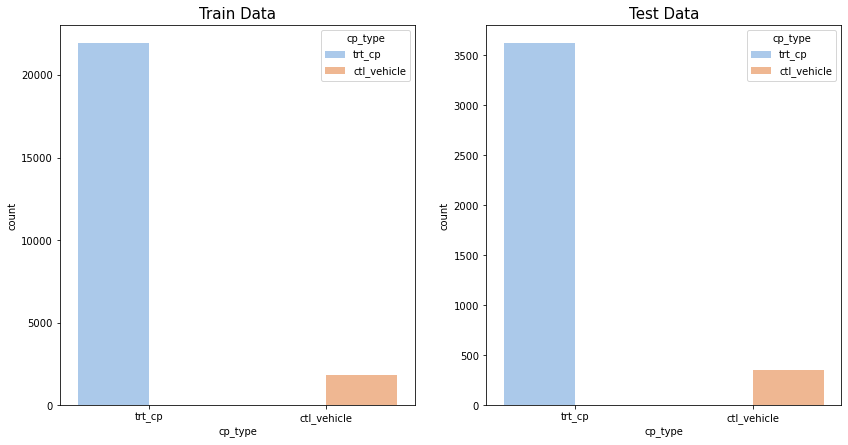

In [12]:
fig, axes = plt.subplots(1,2, figsize=(14, 7))
sns.countplot(data=train_features, x='cp_type', hue='cp_type', ax=axes[0], palette='pastel')
sns.countplot(data=test_features, x='cp_type', hue='cp_type', ax=axes[1], palette='pastel')
axes[0].set_title('Train Data', size=15)
axes[1].set_title('Test Data', size=15)
plt.savefig('image1.png')
plt.show()

* #### cp_time

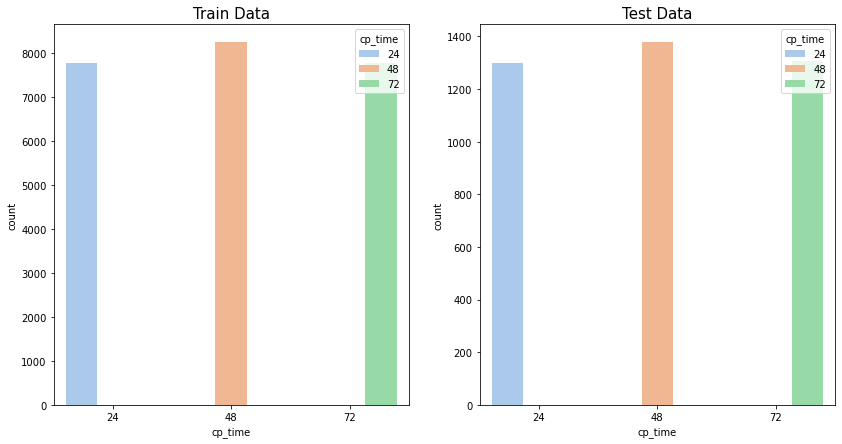

In [13]:
fig, axes = plt.subplots(1,2, figsize=(14, 7))
sns.countplot(data=train_features, x='cp_time', hue='cp_time', ax=axes[0], palette='pastel')
sns.countplot(data=test_features, x='cp_time', hue='cp_time', ax=axes[1], palette='pastel')
axes[0].set_title('Train Data', size=15)
axes[1].set_title('Test Data', size=15)
plt.savefig('image2.png')
plt.show()

* #### cp_dose

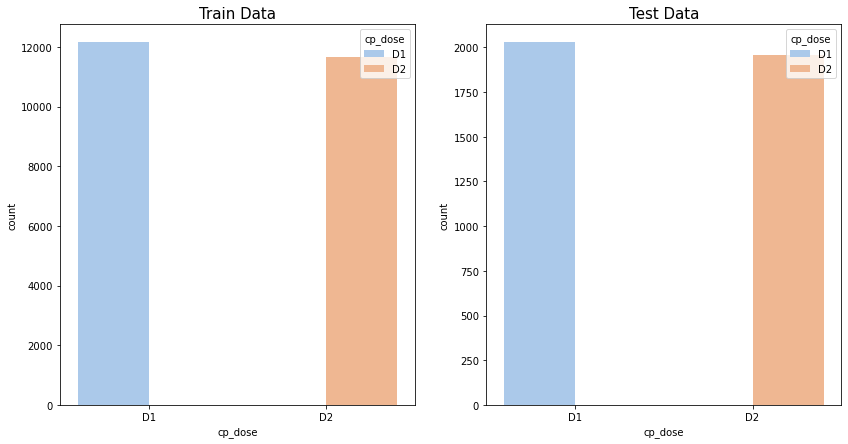

In [14]:
fig, axes = plt.subplots(1,2, figsize=(14, 7))
sns.countplot(data=train_features, x='cp_dose', hue='cp_dose', ax=axes[0], palette='pastel')
sns.countplot(data=test_features, x='cp_dose', hue='cp_dose', ax=axes[1], palette='pastel')
axes[0].set_title('Train Data', size=15)
axes[1].set_title('Test Data', size=15)
plt.savefig('image3.png')
plt.show()

### 2.2 Exploring Cell Viability Data

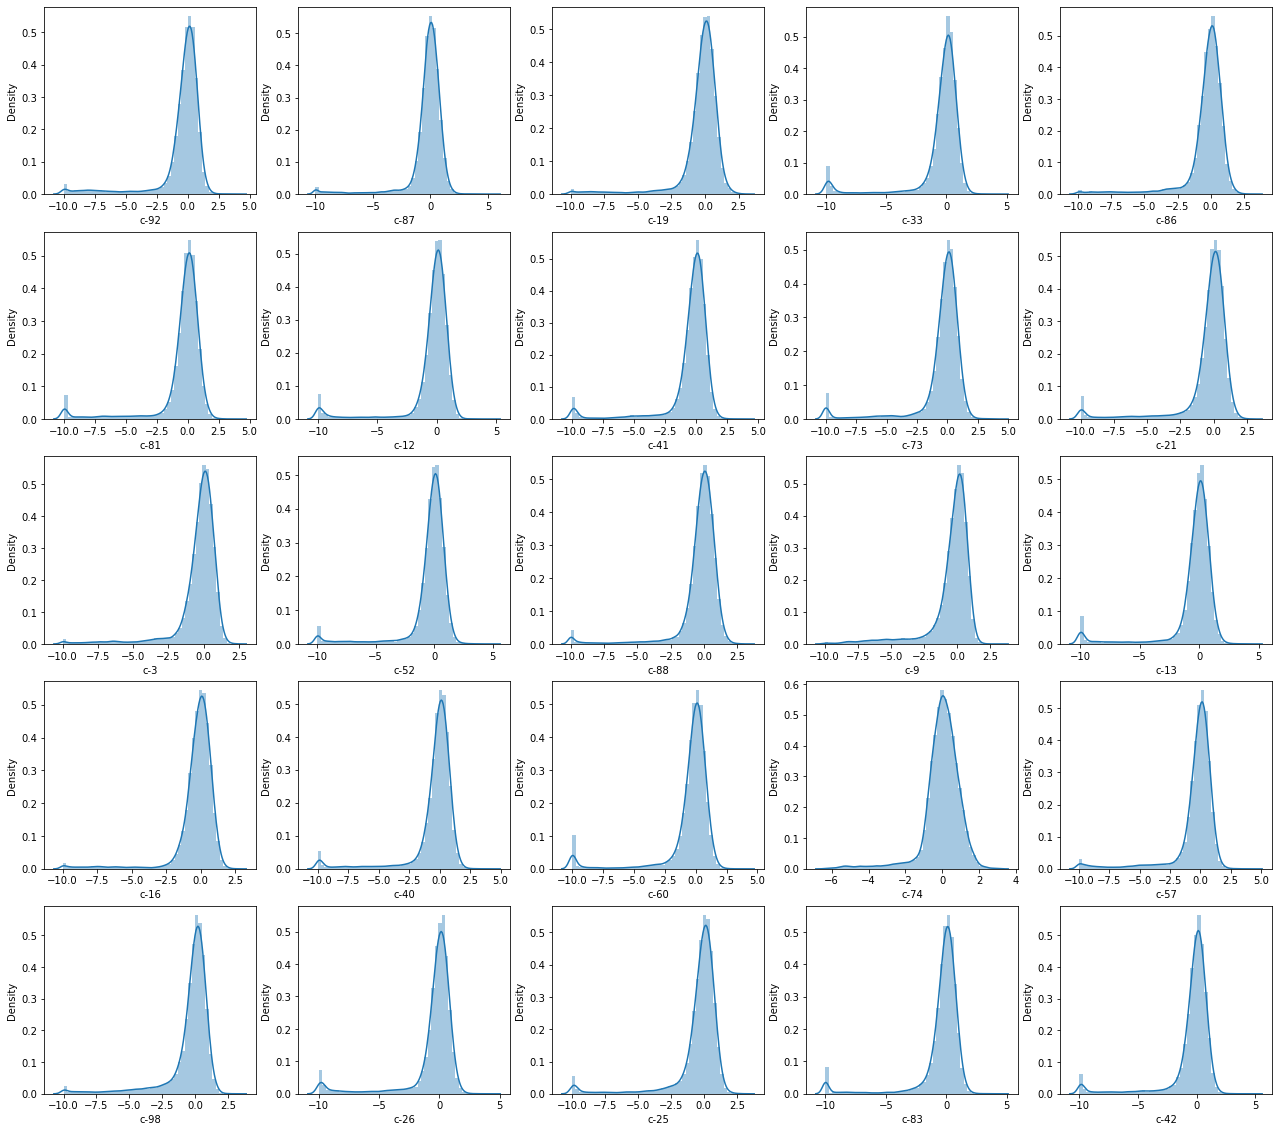

In [15]:
fig, axes = plt.subplots(5,5, figsize=(22,20))
random.seed(20)
count=0
random_cols = random.sample(cell_viability_features, 25)
for i in range(5):
    for j in range(5):
        sns.distplot(train_features[random_cols[count]], ax=axes[i][j])
        count+=1


### Correlation between cell viability features

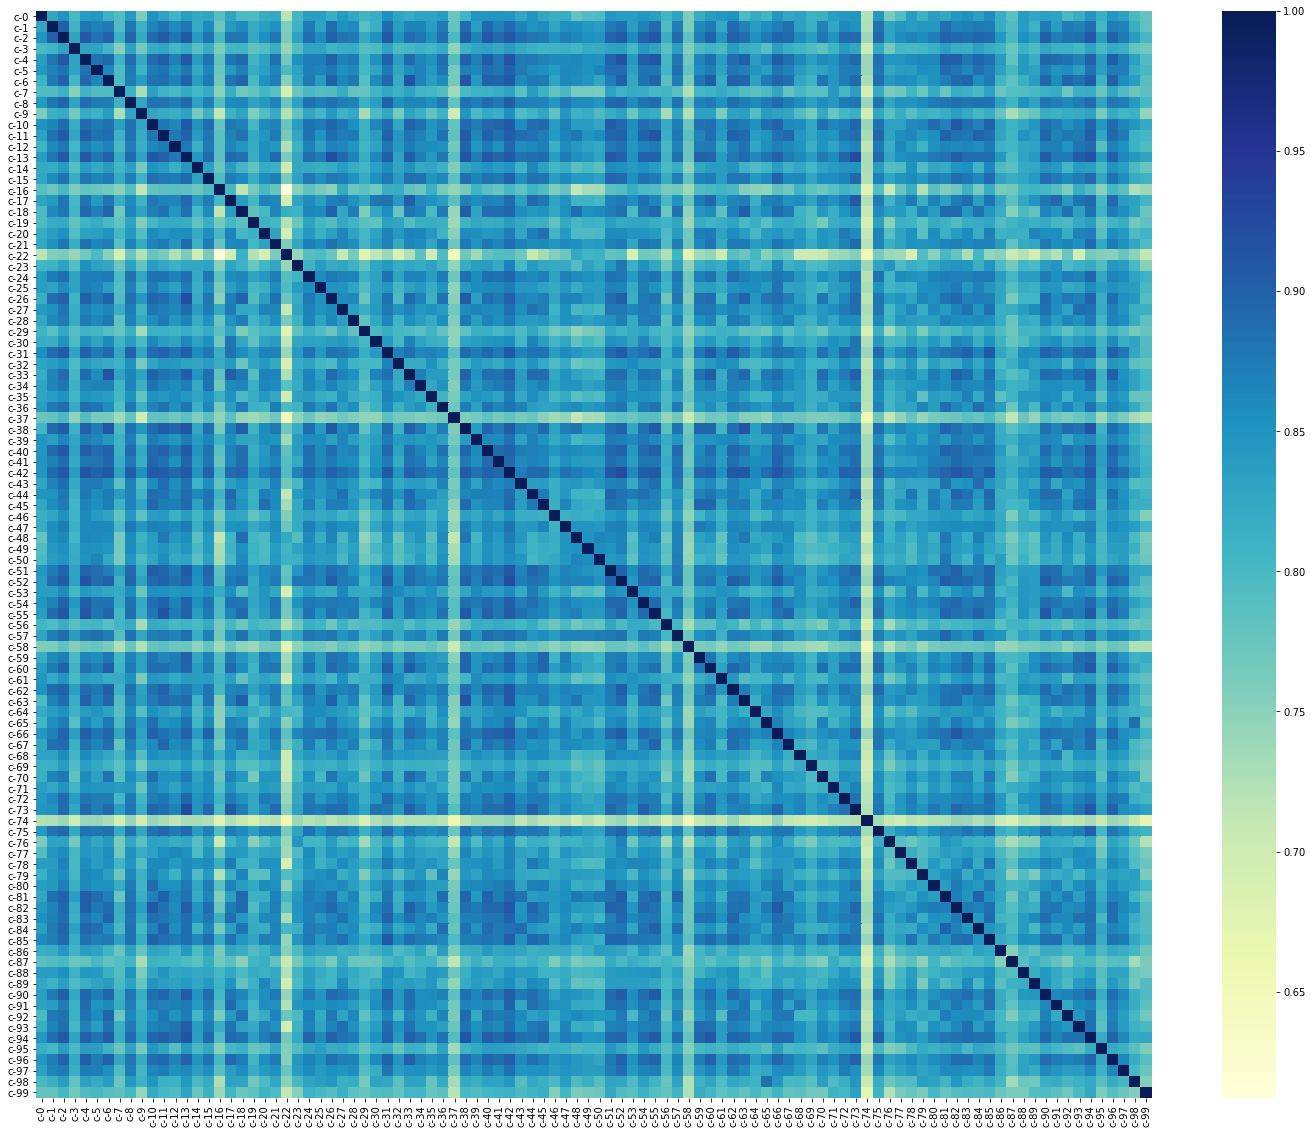

In [16]:
corr = train_features[cell_viability_features].corr()
fig, ax = plt.subplots(figsize=(25,20)) 
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, ax=ax, cmap="YlGnBu")
plt.savefig('image4.png')

### 2.2 Exploring Gene Expression Data

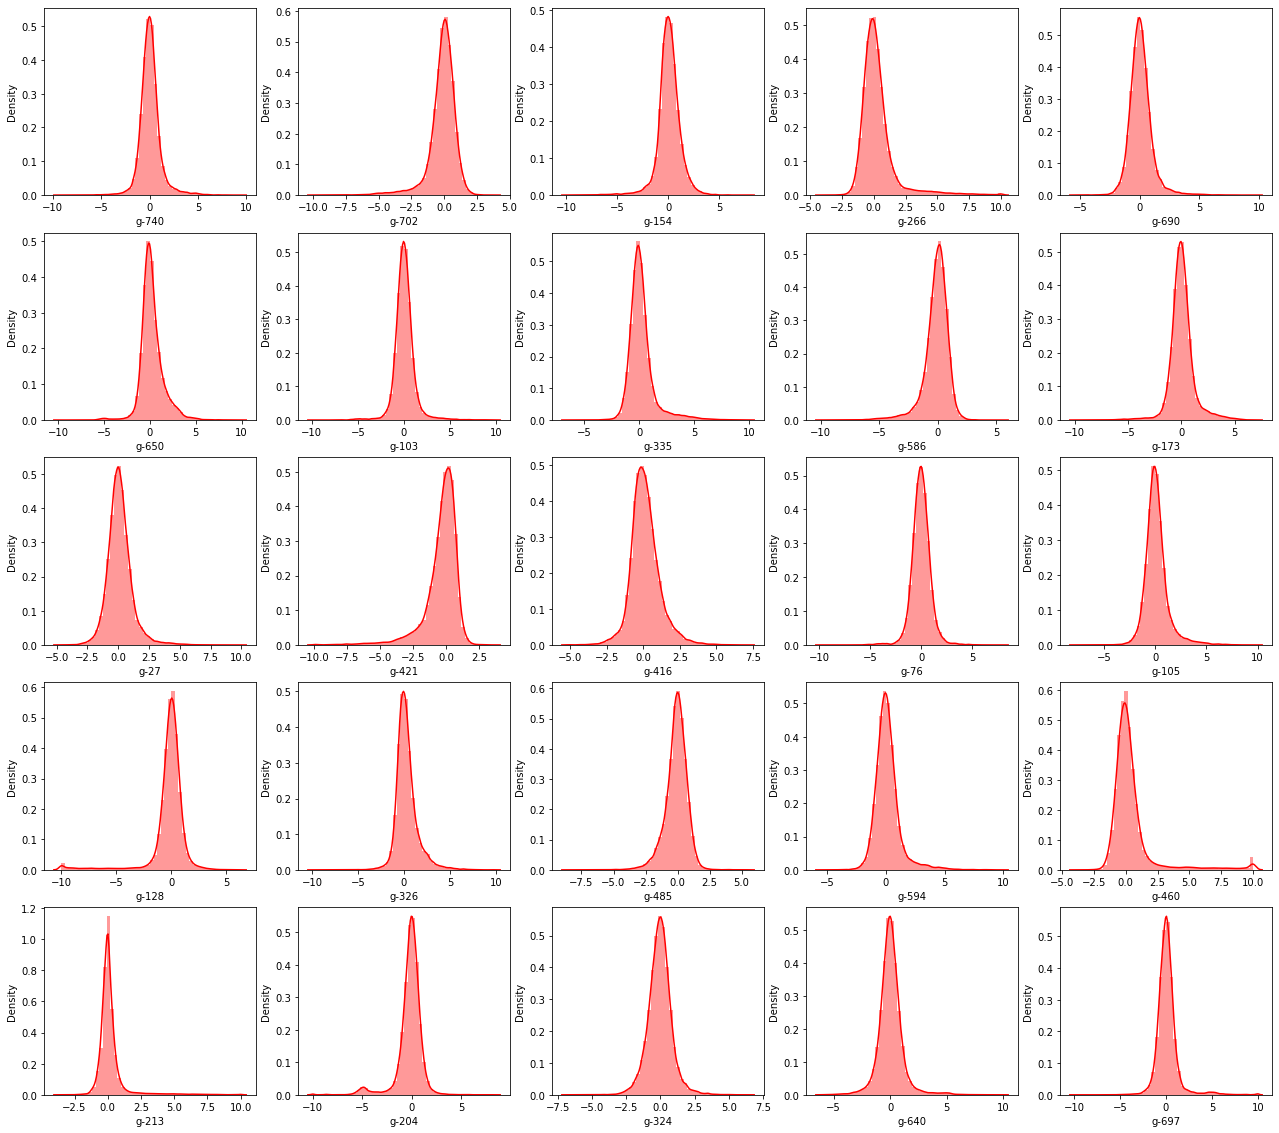

In [17]:
fig, axes = plt.subplots(5,5, figsize=(22,20))
random.seed(20)
count=0
random_cols = random.sample(gene_exp_features, 25)
for i in range(5):
    for j in range(5):
        sns.distplot(train_features[random_cols[count]], ax=axes[i][j], color='r')
        count+=1

### Correlation between randomly selected gene-expression features

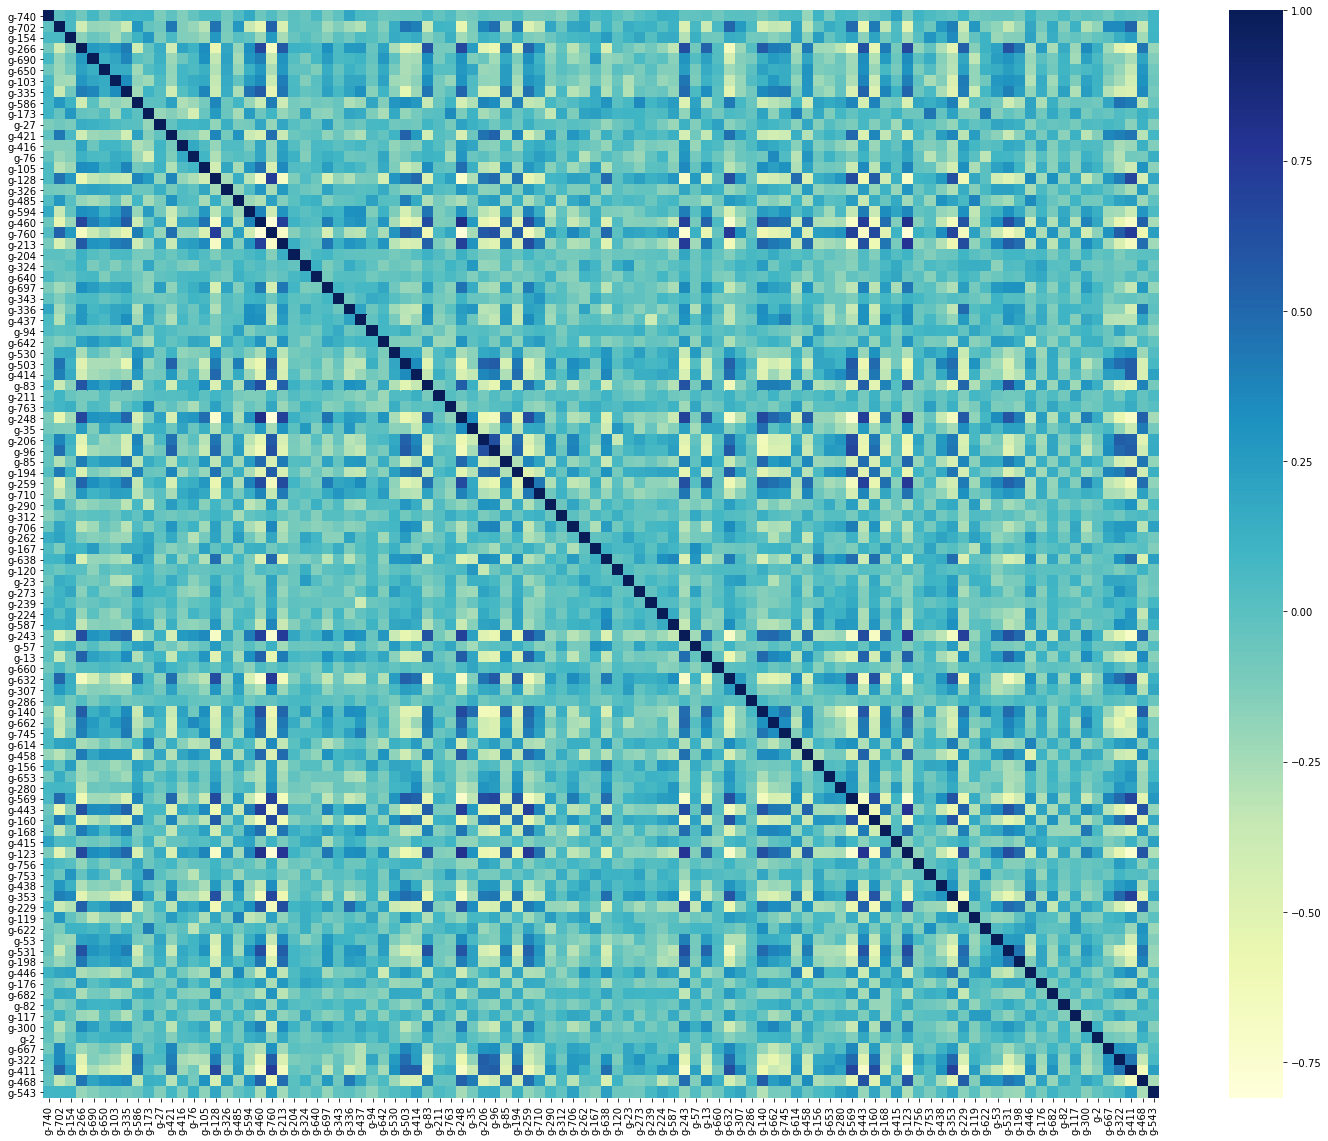

In [18]:
random.seed(20)
corr = train_features[random.sample(gene_exp_features, 100)].corr()
fig, ax = plt.subplots(figsize=(25,20)) 
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, ax=ax, cmap="YlGnBu")
plt.savefig('image5.png')

## 2.3 Scored targets analysis

* The plot below shows distribution of the number of activations per target
* It can be seen that a large number of samples have no activation
* Most samples have 1 activation and very few samples have activations > 2

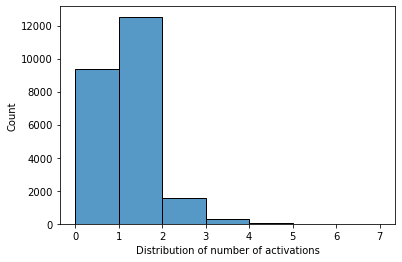

In [19]:
ax = sns.histplot(data=train_targets.sum(axis=1), binwidth=1)
plt.xlabel('Distribution of number of activations')
plt.savefig('image6.png')

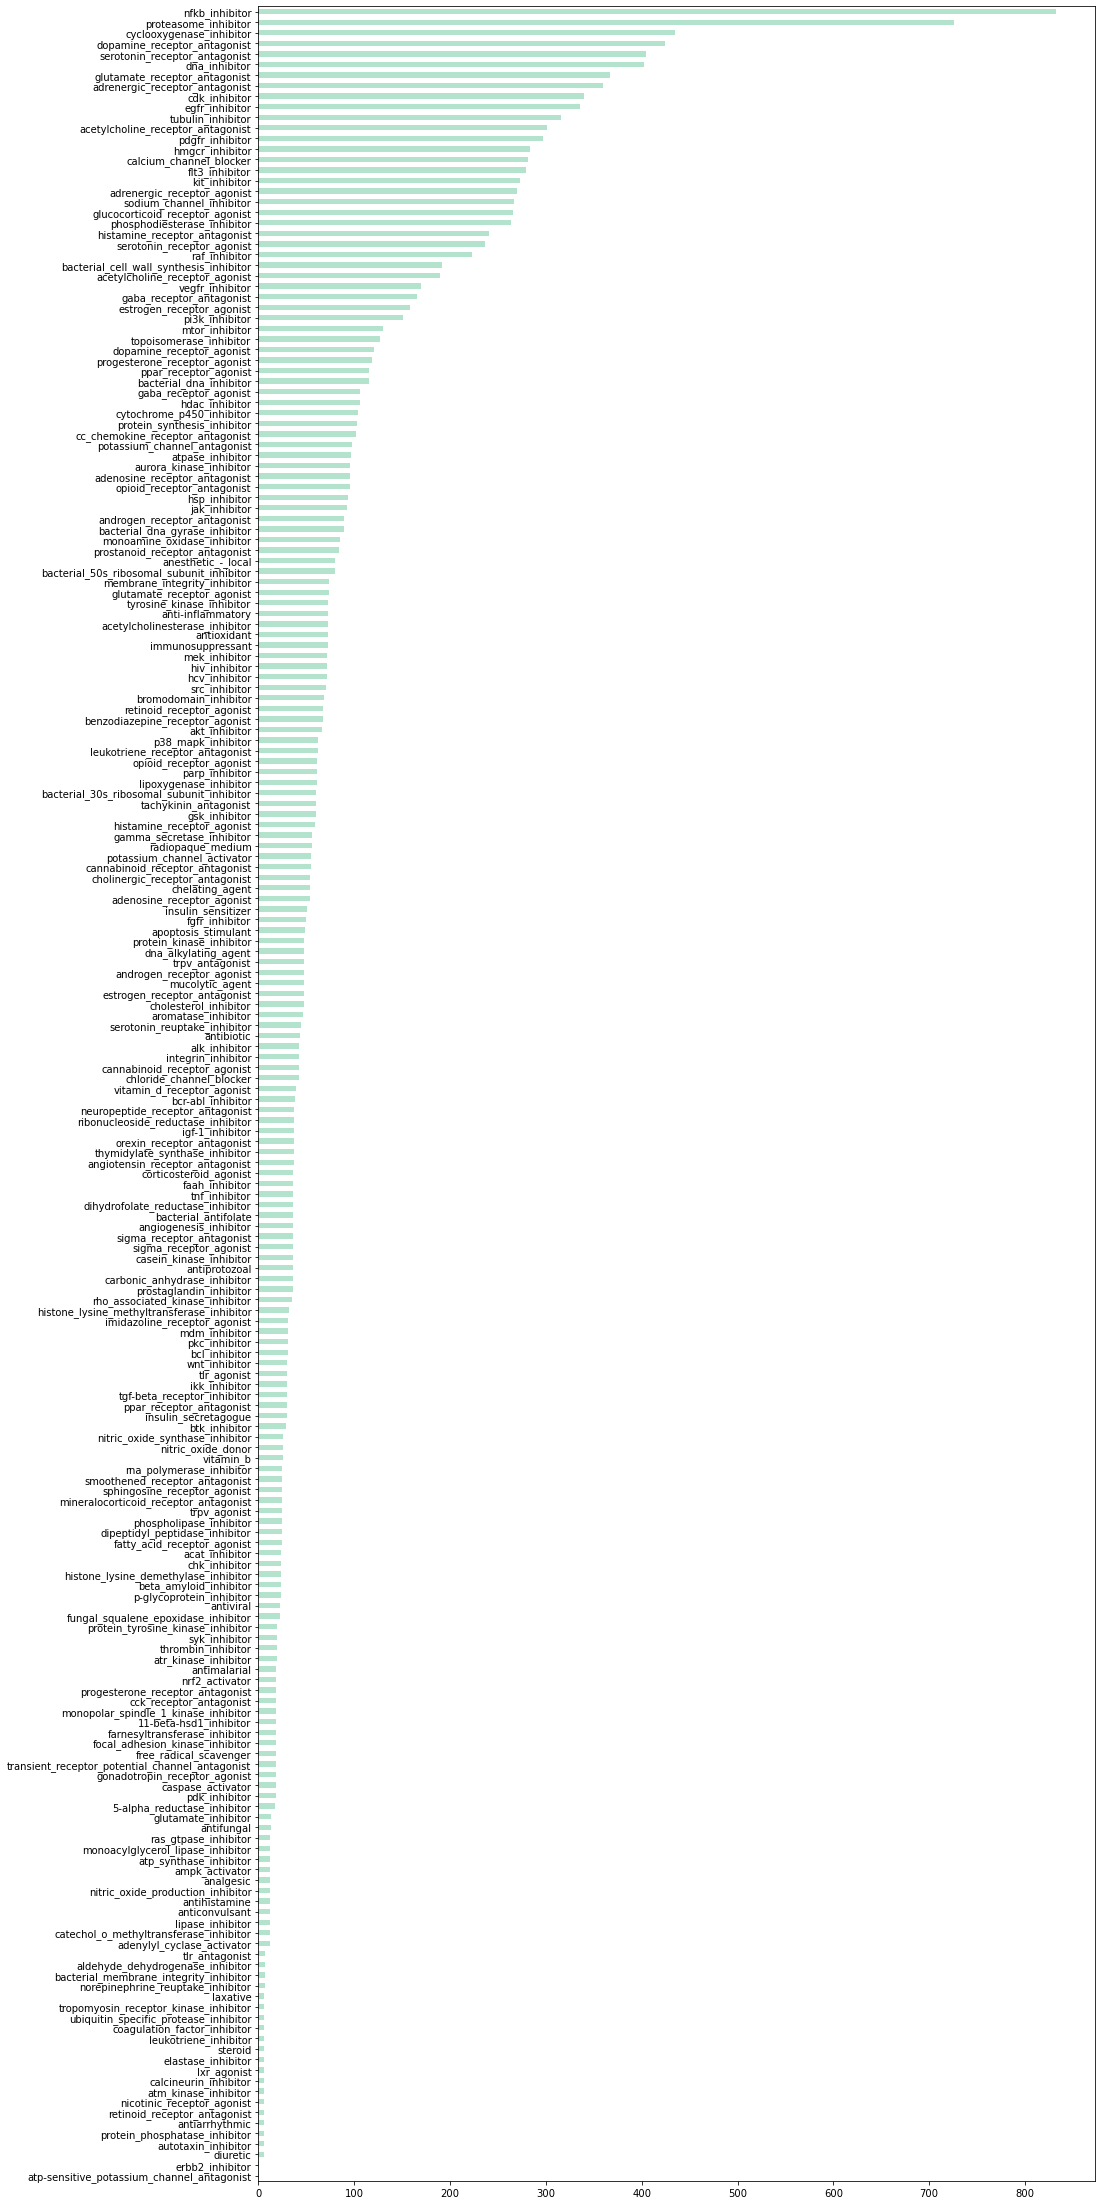

In [20]:
sum_train_targets = train_targets.drop(['sig_id'], axis=1).sum(axis=0).sort_values()
sum_train_targets.plot(kind='barh', figsize=(15,40), colormap='Pastel2')
plt.savefig('image7.png')

## 3. Pre-processing
* The data consists of categorical variables and hence encoding is required. 
* We also need to remove the 'sig_id' columns since it contains no valuable information for our model
* Its stated in the data description that samples treated with a control perturbation `ctrl_vehicle` have no MOA's. 
* So its better to drop these from the training data. 

In [21]:
# delete sig_id
train_features = train_features.drop(['sig_id'], axis=1)
test_features = test_features.drop(['sig_id'], axis=1)
train_targets = train_targets.drop(['sig_id'], axis=1)

In [22]:
# drop rows with `ctrl_vehicle`
train_tar = train_targets[train_features.cp_type != 'ctl_vehicle']
train_feat = train_features[train_features.cp_type != 'ctl_vehicle']

# drop column cp_type -- since now it only contains one value of the categorical variable
train_feat = train_feat.drop(['cp_type'], axis=1)

# encode cp_dose
train_feat['cp_dose'] = train_feat['cp_dose'].map({'D1':0, 'D2': 1})
test_features['cp_dose'] = test_features['cp_dose'].map({'D1':0, 'D2': 1})

# to numpy
train_feat = train_feat.to_numpy()
train_tar = train_tar.to_numpy()

## 4. Classification
* Initially I wanted to try different classification models such as XGBoost, SVM, logistic regression. 
* But since this is a multi-class classifcation problem with a large number of classes (206), it wasn't
  feasible to implement those classifiers using a CPU.
* Hence, it was decided to implement a neural network. 

### Neural Networks

* After researching online, it was deciede that a `Two layer neural network` should be sufficient for this problem.
* After this, the first question arose as to what should be the dimensions of the network i.e number of neurons in each layer.
* Additionally, what is the effect of techniques such as `batch normalization` and `drop out` on the performance. 
* To figure this out, a `grid search` was implemented to analyze all the cases. 
* Network of the following dimensions were analysed: `[512x512, 1024x512, 1024x1024, 2048x1024, 2048x2048, 4096x2048]`
* For each of these dimensions 4 subcases were analysed : `1) With BatchNorm and Dropout 2) Only BatchNorm 3) Only Dropout 4) Neither`

In [23]:
def create_nn(layer1_dims, layer2_dims, input_dims, BN=True, DO=True, l2_reg=0, DO_value=0.5):
    model = Sequential()
    
    # layer 1
    model.add(Dense(layer1_dims, input_dim=input_dims, activation='relu', kernel_regularizer=l2(l2_reg)))
    if BN:
        model.add(BatchNormalization())
    if DO:
        model.add(Dropout(DO_value))
    
    # layer 2
    model.add(Dense(layer2_dims, activation='relu', kernel_regularizer=l2(l2_reg)))
    if BN:
        model.add(BatchNormalization())
    if DO:
        model.add(Dropout(DO_value))
    
    # output layer
    model.add(Dense(206, activation='sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_crossentropy'])
    return model

### Grid Search
* A dictionary has been created to store the results of the grid search

In [24]:
# intialize dictionary to store results in grid search dict
grid_search_dict = {'layer1': [],
                    'layer2': [],
                    'BatchNorm': [],
                    'Dropout': [],
                    'error': [] }

NN_sizes = [[512, 512], [1024, 512], [1024, 1024], [2048, 1024], [2048, 2048], [4096, 2048]]

# set random seeds for reproducible results
from numpy.random import seed
seed(1)
tf.random.set_seed(17) 

In [25]:
# split training data into train and validation
X_train, X_test, y_train, y_test = train_test_split(train_feat, train_tar, test_size=0.3, random_state=42)
case_num = 0

# run grid search 
for network_size in NN_sizes:
    layer1_dims, layer2_dims = network_size
    for BN in [True, False]:
        for DO in [True, False]:
            case_num+=1
            print('Analysing case: {}'.format(case_num))

            # create and fit model
            model = create_nn(layer1_dims=layer1_dims, layer2_dims=layer2_dims, BN=BN, DO=DO, input_dims=train_feat.shape[1], l2_reg=0)
            model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=0)

            # predict and calculate error
            prediction = model.predict(X_test).astype('float64')
            err = log_loss(y_test.ravel(), prediction.ravel())

            # update dictionary
            grid_search_dict['layer1'].append(layer1_dims)
            grid_search_dict['layer2'].append(layer2_dims)
            grid_search_dict['BatchNorm'].append(BN)
            grid_search_dict['Dropout'].append(DO)
            grid_search_dict['error'].append(err)     

Analysing case: 1
Analysing case: 2
Analysing case: 3
Analysing case: 4
Analysing case: 5
Analysing case: 6
Analysing case: 7
Analysing case: 8
Analysing case: 9
Analysing case: 10
Analysing case: 11
Analysing case: 12
Analysing case: 13
Analysing case: 14
Analysing case: 15
Analysing case: 16
Analysing case: 17
Analysing case: 18
Analysing case: 19
Analysing case: 20
Analysing case: 21
Analysing case: 22
Analysing case: 23
Analysing case: 24


### Grid search results
* Results for all the analysed cases can be seen below.
* It can be seen that both batch normalization and dropout increase the performance of our models.
* In general, the best performance is observed when `use both batch norm and dropout`.
* The following two models had the `best results i) 512 x 512 with only dropout ii) 2048x2048 model with both dropout and batch norm.`

In [26]:
# convert grid seach dict to dataframe
grid_search = pd.DataFrame.from_dict(grid_search_dict)
grid_search.head(25)

,layer1,layer2,BatchNorm,Dropout,error
0,512,512,True,True,0.018223
1,512,512,True,False,0.020155
2,512,512,False,True,0.017278
3,512,512,False,False,0.026128
4,1024,512,True,True,0.017939
5,1024,512,True,False,0.020240
6,1024,512,False,True,0.017373
7,1024,512,False,False,0.028629
8,1024,1024,True,True,0.017634
9,1024,1024,True,False,0.022225


In [27]:
# seggregate different cases to analyse the results
case1 = [] # T T
case2 = [] # T F
case3 = [] # F T
case4 = [] # F F

for i in range(24):
    if grid_search['BatchNorm'][i]==True and grid_search['Dropout'][i]==True:
        case1.append(grid_search['error'][i])
    elif grid_search['BatchNorm'][i]==True and grid_search['Dropout'][i]==False:
        case2.append(grid_search['error'][i])
    elif grid_search['BatchNorm'][i]==False and grid_search['Dropout'][i]==True:
        case3.append(grid_search['error'][i])
    elif grid_search['BatchNorm'][i]==False and grid_search['Dropout'][i]==False:
        case4.append(grid_search['error'][i])

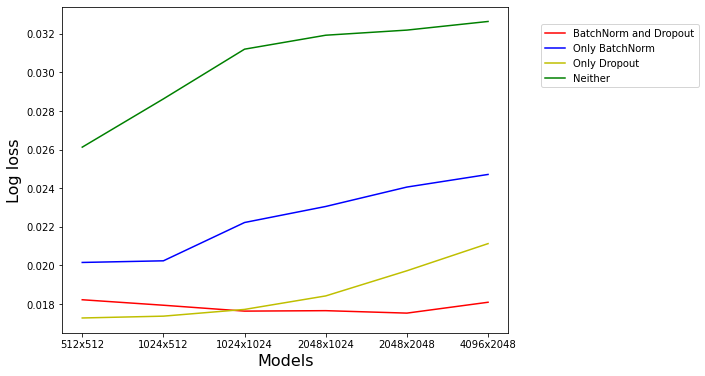

In [28]:
# x labels for the plot
x_ind = [i for i in range(6)]
x_labels = ['512x512', '1024x512', '1024x1024', '2048x1024', '2048x2048', '4096x2048']

plt.figure(figsize=(8,6))
plt.plot(x_ind, case1, 'r', label='BatchNorm and Dropout')
plt.plot(x_ind, case2, 'b', label='Only BatchNorm')
plt.plot(x_ind, case3, 'y', label='Only Dropout')
plt.plot(x_ind, case4, 'g', label='Neither')
plt.ylabel('Log loss',fontsize=16)
plt.xlabel('Models',fontsize=16)
plt.xticks(ticks=x_ind, labels=x_labels)
plt.legend(bbox_to_anchor=(1.25, 0.85), loc=10)
plt.savefig('image8.png', bbox='tight')

### Hyper parameter tuning of the selected model using cross validation
* Grid search was implemented to tune the following hyperparameters:  
  
   1. Dropout rate
   2. Batch size
   3. Regularization parameter

 
* Results for each case were averaged using 5 folds cross validation

In [29]:
dropout = [0.3, 0.5, 0.7]
batch_size = [50, 100, 150]
regularization = [0, 0.005, 0.01]

In [30]:
grid_search_dict = {'dropout': [],
                    'batch_size': [],
                    'regularization': [],
                    'error': []}

Kf = KFold(n_splits=4, random_state=20)

In [31]:
case_num = 0

# loop for grid search
for DO_value in dropout:
    for batch in batch_size:
        for reg in regularization:
            case_num+=1
            print('Analysing case: {}'.format(case_num))
            case_error = 0
            
            # create model
            model = create_nn(layer1_dims=512, layer2_dims=512, BN=False, DO=True, input_dims=train_feat.shape[1], l2_reg=reg, DO_value=DO_value)
            
            # cross validation for each subcase
            for fn, (trn_idx, val_idx) in enumerate(Kf.split(train_feat, train_tar)):
                X_train, X_val = train_feat[trn_idx], train_feat[val_idx]
                y_train, y_val = train_tar[trn_idx], train_tar[val_idx]
                model.fit(X_train, y_train, epochs=10, batch_size=batch, verbose=0)
                
                # predict and calculate error
                prediction = model.predict(X_val).astype('float64')
                err = log_loss(y_val.ravel(), prediction.ravel())
                case_error+=err
            case_error = case_error/4
            grid_search_dict['dropout'].append(DO_value)
            grid_search_dict['batch_size'].append(batch)
            grid_search_dict['regularization'].append(reg)
            grid_search_dict['error'].append(case_error)

Analysing case: 1
Analysing case: 2
Analysing case: 3
Analysing case: 4
Analysing case: 5
Analysing case: 6
Analysing case: 7
Analysing case: 8
Analysing case: 9
Analysing case: 10
Analysing case: 11
Analysing case: 12
Analysing case: 13
Analysing case: 14
Analysing case: 15
Analysing case: 16
Analysing case: 17
Analysing case: 18
Analysing case: 19
Analysing case: 20
Analysing case: 21
Analysing case: 22
Analysing case: 23
Analysing case: 24
Analysing case: 25
Analysing case: 26
Analysing case: 27


### Analyze results of the grid search
* The data frame summarizes the results of the grid search
* The plot shows the effect of regularization. Models with no regularization perform the best.

In [32]:
grid_search_hyper = pd.DataFrame.from_dict(grid_search_dict)
grid_search_hyper['index'] = [i for i in range(1,28)]
grid_search_hyper.head(27)

,dropout,batch_size,regularization,error,index
0,0.3,50,0.000,0.009693,1
1,0.3,50,0.005,0.020835,2
2,0.3,50,0.010,0.020992,3
3,0.3,100,0.000,0.009554,4
4,0.3,100,0.005,0.021036,5
5,0.3,100,0.010,0.021022,6
6,0.3,150,0.000,0.009828,7
7,0.3,150,0.005,0.020925,8
8,0.3,150,0.010,0.021025,9
9,0.5,50,0.000,0.012911,10


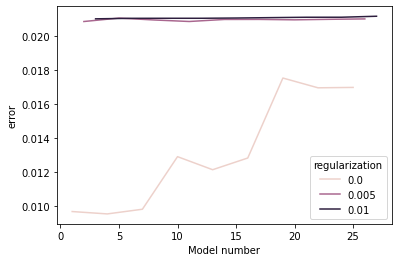

In [33]:
ax = sns.lineplot(data=grid_search_hyper, x='index', y='error', hue='regularization')
plt.xlabel('Model number')
plt.savefig('reg.png')

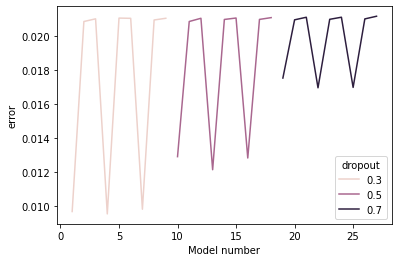

In [34]:
ax = sns.lineplot(data=grid_search_hyper, x='index', y='error', hue='dropout')
plt.xlabel('Model number')
plt.savefig('dropout.png')

### Best model
* The following model has the best performance : 
    1. Drop_out_rate = 0.3
    2. batch_size = 100
    3. regularization = 0

In [35]:
min_error_ind = grid_search_hyper[['error']].idxmin() 
best_model = grid_search_hyper.iloc[min_error_ind, :]
print(best_model)

   dropout  batch_size  regularization     error  index
3      0.3         100             0.0  0.009554      4


### Learning curves for the best model
* The learning cureves of the model have been plotted. 
* Both the loss on the training set and the validation set can be seen in the plots below
* The point where the validation curve starts going up is where we can say that the model starts over fitting.

In [36]:
model = create_nn(layer1_dims=512, layer2_dims=512, BN=False, DO=True, input_dims=train_feat.shape[1], l2_reg=0.0, DO_value=0.3)
history = model.fit(train_feat, train_tar,epochs=10, batch_size=100, verbose=0, validation_split=0.33, shuffle=True)

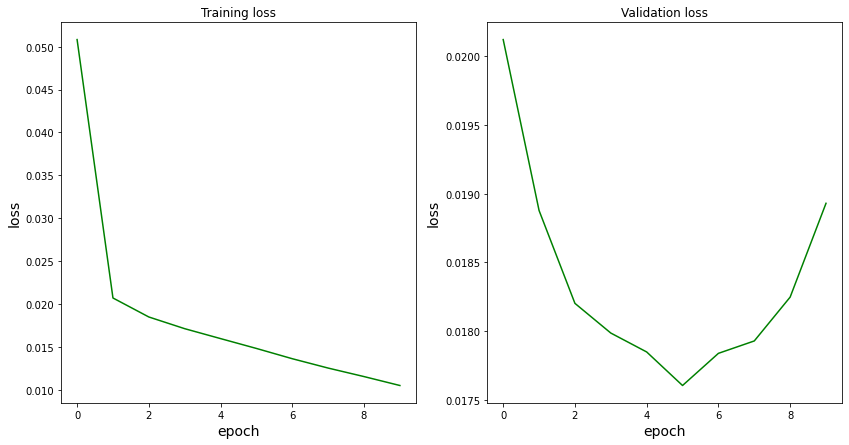

In [37]:
fig, axes = plt.subplots(1,2, figsize=(14, 7))

axes[0].plot(history.history['loss'], 'g')
axes[0].set_title('Training loss')
axes[0].set_ylabel('loss', fontsize=14)
axes[0].set_xlabel('epoch', fontsize=14)

axes[1].plot(history.history['val_loss'], 'g')
axes[1].set_title('Validation loss')
axes[1].set_ylabel('loss', fontsize=14)
axes[1].set_xlabel('epoch', fontsize=14)
plt.savefig('learning_curves.png')

## Final model and submission
* The final model was trained on the complete training dataset. 
* The code below also creates a submission in the suitable format.

In [38]:
model = create_nn(layer1_dims=512, layer2_dims=512, BN=False, DO=True, input_dims=train_feat.shape[1], l2_reg=0.0, DO_value=0.3)
model.fit(train_feat, train_tar,epochs=5, batch_size=100, verbose=0)

In [39]:
test_feat= test_features.drop(['cp_type'], axis=1)
test_prediction = model.predict(test_feat)
row_zeros = [ 0 for i in range(206)]
test_prediction[test_features.cp_type == 'ctl_vehicle', :] = row_zeros

In [40]:
sample_submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))
sample_submission.iloc[:,1:] = test_prediction
sample_submission.to_csv('submission.csv', index=False)